# Convert Data Files to WISP Format for Spectral Fitting

**Author:** Mitchell Revalski

**Adapted:** Kalina V. Nedkova and James Colbert

**Last Updated:** July 12, 2024

***

## Jupyter Notebook for the MUSE Ultra Deep Field Program

This notebook was created by Dr. Mitchell Revalski to convert the HST passage and VLT MUSE spectroscopic files provided by Dr. Nor Pirzkal and Dr. Matteo Fossati into a format that is compatible with the version of the WISP spectroscopic fitting routine that is being used for the MUDF program.

Please send questions, comments, and suggestions to Mitchell Revalski at [mrevalski@stsci.edu](mrevalski@stsci.edu). Thank you, and have a nice day!

***

## This version has been adapted for PASSAGE

The updated version of this notebook converts JWST 1D spectroscopic files produced by grizli into a format that is compatible with the version of the WISP spectroscopic fitting routine that is being used for the PASSAGE program.

Moreover, in an optional step 3, 1D spectroscopic files are created for the individual orientations (R grism & C grism). The location of the beam files from grizli needs to be specified for this step. 

Please send questions, comments, and suggestions w.r.t. the PASSAGE updates to Kalina at [knedkova@stsci.edu](knedkova@stsci.edu). 
Special thank you to James Colbert for fixing a bug that caused this code to crash if the F150W grism filter does not exist. 

***


## Software

The Python environment (ac6) used to run this notebook was built using conda:<br>
<code>
(base) asteropaios:Documents mrevalski$ conda create -n ac6 stsci
(base) asteropaios:Documents mrevalski$ conda activate ac6
(ac6) asteropaios:Documents mrevalski$ conda update drizzlepac
(ac6) asteropaios:Documents mrevalski$ conda deactivate
</code>

The jupyter notebook can then be run using the following call sequence:<br>
<code>
(base) asteropaios:conversion mrevalski$ conda activate ac6
(ac6) asteropaios:conversion mrevalski$ jupyter notebook
</code>

The critical package versions include:<br>
<code>
Python Version [GCC Clang 10.0.0] 3.6.13 |Anaconda, Inc.|
(default, Feb 23 2021, 12:58:59) 
numpy Version -> 1.19.2 
astropy Version -> 4.0.2
</code>  

***

## Table of Contents <a class="anchor" id="tag0"><a>


**&emsp; 1) [Setup Options](#setup)<br>**
**&emsp; 2) [Convert PASSAGE](#passage)<br>**
**&emsp; 3) [Create 1D spectra for each orientation](#orientations)<br>**
    
*** 

## Imports

The following packages are required to run the Jupyter Notebook:
 - *os* - change and make directories
 - *glob* - determine files in folders
 - *numpy* - math and array functions
 - *pandas* - data structure functions    
 - *astropy* - file and data handling
      - *io.fits* - import FITS files
      - *table.Table* - display formatted tables

In [1]:
import os
import glob
import numpy as np
import pandas as pd
from astropy.io import fits
from astropy.table import Table, vstack
from time import time

import grizli
print(grizli.__version__)

from grizli import utils, multifit
from grizli.pipeline import auto_script

utils.set_warnings()

1.11.10
Failed to `import dust_attenuation`
Install from the repo with $ pip install git+https://github.com/karllark/dust_attenuation.git


## Setup Options  <a class="anchor" id="setup"><a>
[Table of Contents](#tag0)

In [2]:
# main directory
main_directory = '/Users/knedkova/Work/2024PASSAGE/'
par_names = ['Par28']

# grism data directory
spec1D_directory = main_directory+'data/'+par_names[0]+'/spec1D/'

# where all the parallel field data live
data_directory = main_directory+'data/'+par_names[0]+'/'

In [3]:
os.chdir(spec1D_directory)

## Convert passage  <a class="anchor" id="passage"><a>
[Table of Contents](#tag0)

1. In order for the wavelet solutions to work, the 'RADESYS' keyword in the header must be either updated or removed. 

In [4]:
#check if already updated for first object. If yes -> do nothing, if not -> update RADESYS in all fits headers

for k in par_names:
    files = glob.glob(main_directory+'data/'+str(k)+'/Stamps/*.fits')
    test_file = fits.open(files[0])
    header = test_file[2].header
    
    if header['RADESYS'] != 'ICRS':
        print('Headers are not updated. Updating all now.')
        hdulist = fits.open(main_directory+'data/'+str(k)+'/Stamps/*.fits')

        for j in files:
            # Open the file header for viewing and load the header
            hdulist = fits.open(j)
            for i in range(len(hdulist)):
                header = hdulist[i].header
                try: header['RADESYS'] = 'ICRS'
                except: print('no RADESYS in header')
            
            hdulist.writeto(j, overwrite='True')


2. Now create 1D spectral files

In [12]:
# flag for creating the output files regardless of whehter they already exist
# True = create new files
# False = create new files only if they do not exist 
create_files_anyway = True

In [14]:
for i in par_names:
    
    try:os.mkdir(data_directory)
    except:print('I did not make your directory')
    try:
        os.chdir(data_directory)
        os.mkdir('Spectra')
    except:print('I did not make your directory')
    
    os.chdir(spec1D_directory+str(i))
    print('moving to:', spec1D_directory+str(i))
    files = sorted(glob.glob('*1D.fits'))

    # Check if converted files already exist. If they do not, carry on with the conversion. 
    # Otherwise, this step can be skipped. 
    # Here, I just check if there are more converted files than objects (there can be 1-3 per object)
    # depending on how many filters are available for each object
    already_converted_files = glob.glob(data_directory + 'Spectra/*.dat')
    if len(files) >= len(already_converted_files) or create_files_anyway == True:
        print(len(already_converted_files))
        print(len(files))
    
        print('\nThere are ' + str(len(files)) + ' PASSAGE files to convert.\n')
        for f in files:
            os.chdir(spec1D_directory+str(i))
            #os.chdir(spec1D_directory+par_names[0]+'/')
            fff = fits.open(f)
            print(fff.info)

            for ext in range(1, len(fff)):
                
                tb = Table.read(fff[ext], format='fits').to_pandas()
                t_out = pd.DataFrame({})
            
                t_out['wave'] = tb['wave']
                t_out['flux'] = tb['flux']/tb['flat']
                t_out['error'] = tb['err']/tb['flat']
                t_out['contam'] = tb['contam']/tb['flat']
                t_out['zeroth'] = np.zeros(len(tb['wave'])).astype('int')
                t_out = Table.from_pandas(t_out)
                t_out = t_out.filled(0.0) # Replace nans with zeros
                # Spectra dispersed beyond the chip have zero fluxes that must be replaced to prevent crashes in fitting.
                t_out['flux'][np.where(t_out['flux'] == 0.0)] = np.median(t_out['flux'][np.where(t_out['flux'] != 0.0)])
                t_out['error'][np.where(t_out['error'] == 0.0)]=np.median(t_out['error'][np.where(t_out['error'] != 0.0)])
    
                print('saving to '+ data_directory + 'Spectra' )
                os.chdir(data_directory + 'Spectra' )
    
                # Write out the updated files.
                if fff[ext].header['EXTNAME'] == 'F200W':
                    _indexes_ = [i for i in range(len(fff[ext].data))]
                    try:_indexes_ = [i for i in _indexes_ if t_out['wave'][i] > max(Table.read(fff[ext-1])['wave']) ]
                    except:pass
                    t_out[_indexes_].write(os.path.basename(f).replace('1D.fits', 'G200_1D.dat'), 
                            format='ascii.fixed_width_two_line', overwrite=True)      
                
                # Write out the updated files.
                if fff[ext].header['EXTNAME'] == 'F150W':
                    #t_out.write(os.path.basename(f).replace('1D.fits', 'G150_1D_uncomb.dat'), 
                    t_out.write(os.path.basename(f).replace('1D.fits', 'G150_1D.dat'), 
                            format='ascii.fixed_width_two_line', overwrite=True)
                    
                elif fff[ext].header['EXTNAME'] == 'F115W':
                    t_out.write(os.path.basename(f).replace('1D.fits', 'G115_1D.dat'), 
                            format='ascii.fixed_width_two_line', overwrite=True)

        # THE BELOW IS NO LONGER NEEDED. 
    
        # Now that the .dat files have been created/updated, need to combine the F200W with the F150W
        # # since the next code expects only 2 grism filters.
        # os.chdir(data_directory + '/Spectra' )

        # target_dir = data_directory + 'Spectra'
        # F200s = glob.glob(target_dir+'/*G200_1D.dat')
        
        # for i in range(len(F200s)):
            # F150s = F200s[i].split('G200_1D.dat')[0]+str('G150_1D_uncomb.dat')
            # tb_200 = Table.read(F200s[i], format='ascii')
            # if os.path.exists(F150s):
                # tb_150 = Table.read(F150s, format='ascii')
                    
            # tout = vstack([tb_150, tb_200])
            # print(os.path.basename(F150s).replace('G150_1D_uncomb.dat', 'G150_1D.dat'))
                
            # tout.write(os.path.basename(F150s).replace('G150_1D_uncomb.dat', 'G150_1D.dat'), 
                            # format='ascii.fixed_width_two_line', overwrite=True)


    else: print('It appears the .dat files were already created for this field. Skipping this step.')
    


I did not make your directory
I did not make your directory
moving to: /Users/knedkova/Work/2024PASSAGE/data/Par28/spec1D/Par28
26875
2754

There are 2754 PASSAGE files to convert.

<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x29842b150>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298203290>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298200890>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x297cdf910>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x29840e610>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2983f0f10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981df290>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981defd0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
savi

2024-07-30 15:49:49,596 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:49:49,597 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:49:49,597 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x298445510>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29724e890>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29840c450>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29840ab10>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x29840d990>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29827be90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981de350>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29855d310>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:49:57,630 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:49:57,630 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:49:57,631 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x28a2a2910>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298278e50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298299b50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2983ecf90>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x298432e90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29842b610>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298433710>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298431d90>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:49:58,170 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:49:58,171 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:49:58,171 - stpipe - WARNING - 
2024-07-30 15:49:58,178 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:49:58,178 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:49:58,178 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x298505690>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298566b90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298585b50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298432290>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2984091d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2984bb150>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29805cc50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29827ac50>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:49:58,875 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:49:58,876 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:49:58,876 - stpipe - WARNING - 
2024-07-30 15:49:58,882 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:49:58,883 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:49:58,883 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2944a6a90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298447610>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2984e7750>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2982a4390>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2944a4050>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29840a290>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298587c90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2984cb9d0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:50:04,128 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:50:04,128 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:50:04,129 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2985054d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x294468750>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298200150>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29856e9d0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2984311d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2944a6290>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2944a68d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298278950>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:50:09,424 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:50:09,424 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:50:09,425 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x298507f90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29856d7d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29829ef90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298567f90>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x298049b50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298181250>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2984a3850>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29803a610>]>


2024-07-30 15:50:09,620 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:50:09,620 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:50:09,620 - stpipe - WARNING - 
2024-07-30 15:50:09,627 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:50:09,628 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:50:09,628 - stpipe - WARNING - 


saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2982491d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29807a610>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298275a10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29830c5d0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x298281c10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298048b10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29837fe10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298107150>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra


2024-07-30 15:50:13,640 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:50:13,640 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:50:13,640 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x29840c350>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29848c2d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981fbdd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x297cdfb90>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x298203250>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298444f90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981db410>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29840f0d0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:50:15,790 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:50:15,790 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:50:15,790 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2984cc510>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2984988d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x28a29c6d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29840e390>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2981811d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298325d50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298445210>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981bd710>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:50:21,700 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:50:21,700 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:50:21,700 - stpipe - WARNING - 
2024-07-30 15:50:21,707 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:50:21,707 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:50:21,707 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2984cf350>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981fab90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981bd8d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29848c310>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2984ce650>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2944a6750>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x297cc5410>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2982bfe10>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:50:28,829 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:50:28,830 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:50:28,830 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2944a7e90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298430ad0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981806d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298281e10>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x29840d5d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29856ead0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2984a4d10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981ea4d0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra


2024-07-30 15:50:29,038 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:50:29,039 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:50:29,039 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2982591d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981bfad0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2984b5c50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298504d90>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x298275410>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981b4650>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2984e6710>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298279690>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:50:30,251 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:50:30,251 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:50:30,251 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x298567190>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2984e6990>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298183190>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29804b790>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2981e9a90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981bc610>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298337ad0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29840f050>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:50:32,263 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:50:32,264 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:50:32,264 - stpipe - WARNING - 
2024-07-30 15:50:32,271 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:50:32,271 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:50:32,271 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x298564390>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298183810>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981bee10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298504810>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2981bcfd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29805f710>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981e9490>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29829c990>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:50:34,729 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:50:34,729 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:50:34,729 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2982a4b10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2944a70d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29840ded0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981b7250>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2984091d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298446310>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298324850>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298584f90>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:50:36,421 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:50:36,421 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:50:36,421 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x29840e610>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x28a2a2910>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2984b6010>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298324850>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2981f80d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298273010>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29805f990>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981dcb10>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:50:37,135 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:50:37,135 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:50:37,136 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x298250890>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2982bfdd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981db3d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298506410>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2984a6250>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29804a850>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981bf1d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2984b9a50>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:50:45,382 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:50:45,383 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:50:45,383 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x29840ad50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2984b4810>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29840fdd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29431b350>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2982591d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298200350>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2944a4a50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29840b590>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:50:49,510 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:50:49,510 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:50:49,510 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x29804b410>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29800e350>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981e9650>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2980f2250>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2981ea9d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981ad490>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2983fac10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x297246fd0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:51:00,685 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:51:00,685 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:51:00,686 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x298249350>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x297c963d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2984ce250>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29840f250>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2984a1010>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x294413f50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2984a4d10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29848c310>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:51:04,887 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:51:04,887 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:51:04,888 - stpipe - WARNING - 
2024-07-30 15:51:04,894 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:51:04,894 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:51:04,894 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2984ce0d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x297c94310>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981ea750>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2984b4610>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29724f8d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2984baf90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2982741d0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x29724c310>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x294469610>, <astropy.io.fits.hdu.table.BinT

2024-07-30 15:51:08,123 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:51:08,123 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:51:08,123 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2981eb390>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981bfad0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981d81d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298048e90>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x297fcf590>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29431be90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x297c4ca90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298566890>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:51:09,355 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:51:09,356 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:51:09,356 - stpipe - WARNING - 


saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x298446a90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298251a90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981d9f90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2982a4390>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2984ce910>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2984a2910>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981eb250>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298301bd0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra


2024-07-30 15:51:10,585 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:51:10,585 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:51:10,585 - stpipe - WARNING - 
2024-07-30 15:51:10,593 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:51:10,593 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:51:10,593 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x298507bd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29813aa10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981ea2d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29829cc90>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x298584b90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2982bc750>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29840bd50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981bc090>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:51:15,688 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:51:15,689 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:51:15,689 - stpipe - WARNING - 
2024-07-30 15:51:15,695 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:51:15,696 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:51:15,696 - stpipe - WARNING - 


saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x298409a90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x297c8ef90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29848c410>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981b4f50>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2981d9b10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29849a9d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2982bfc50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29840ee50>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra


2024-07-30 15:51:20,896 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:51:20,897 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:51:20,897 - stpipe - WARNING - 
2024-07-30 15:51:20,903 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:51:20,904 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:51:20,904 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x298586b50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981e9cd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981ea990>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298430050>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2981811d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29506f290>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981d96d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298440290>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:51:22,288 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:51:22,288 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:51:22,288 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x298138b90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298584c90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981da650>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2982be210>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2981bde10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2982484d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298272590>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298504b10>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:51:24,338 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:51:24,338 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:51:24,338 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x29827ab10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298446790>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981df410>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298565190>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2984e5990>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981fb610>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298584650>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29840ed90>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:51:24,847 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:51:24,848 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:51:24,848 - stpipe - WARNING - 
2024-07-30 15:51:24,854 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:51:24,854 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:51:24,854 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x298048b10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298564490>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29840c810>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x297c8e3d0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x297c8e6d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29848c610>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2982480d0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x29805d190>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29848cd10>, <astropy.io.fits.hdu.table.BinT

2024-07-30 15:51:25,396 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:51:25,397 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:51:25,397 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2984061d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298565790>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298327710>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298270b50>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x29855e850>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981d8b50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29856e7d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981838d0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:51:27,946 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:51:27,946 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:51:27,946 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x297cdfcd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981f9490>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2984a3650>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x297c8e850>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x29829e310>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2984a3650>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981e9490>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298273f10>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:51:42,073 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:51:42,073 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:51:42,073 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x298433150>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2984a5e50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29855ee50>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x298259dd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29804b750>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2982bf8d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x297c8eb90>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2984091d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298566890>, <astropy.io.fits.hdu.table.BinT

2024-07-30 15:51:44,324 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:51:44,324 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:51:44,324 - stpipe - WARNING - 


saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2982bccd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298431010>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981e96d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29840a210>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2983f8910>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981bcf90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298507050>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298278a50>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra


2024-07-30 15:51:45,972 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:51:45,972 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:51:45,973 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x29804b250>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981eb110>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x297c8eed0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x297cc48d0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2981dc1d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981aec90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2982bc150>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981078d0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:51:50,476 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:51:50,476 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:51:50,476 - stpipe - WARNING - 
2024-07-30 15:51:50,482 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:51:50,483 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:51:50,483 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2984b6110>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981be2d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298048fd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298337ed0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x298433fd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2982825d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x297263250>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2984cec50>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:51:52,844 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:51:52,844 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:51:52,844 - stpipe - WARNING - 
2024-07-30 15:51:52,851 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:51:52,851 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:51:52,851 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x29804b490>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2982a5510>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2944a5110>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29855de50>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x297263250>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981b7ed0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298253290>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298432e90>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:51:55,060 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:51:55,061 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:51:55,061 - stpipe - WARNING - 
2024-07-30 15:51:55,067 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:51:55,067 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:51:55,067 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2981b4550>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29724f810>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981ac450>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298049090>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra


2024-07-30 15:51:55,269 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:51:55,269 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:51:55,269 - stpipe - WARNING - 
2024-07-30 15:51:55,275 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:51:55,275 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:51:55,276 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2980491d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298431690>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298327250>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981bd6d0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2984a39d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29856f2d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2982a7190>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29825f310>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:51:56,475 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:51:56,476 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:51:56,476 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2984a1b10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298275210>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x297c4e050>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298325d90>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x298203610>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298585dd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x297c52510>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298433550>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:51:57,148 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:51:57,148 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:51:57,149 - stpipe - WARNING - 
2024-07-30 15:51:57,155 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:51:57,155 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:51:57,155 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2981ddf10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298337d10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298445ed0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29829e910>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2981e8ed0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298259bd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29849b8d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298504150>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:52:07,221 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:52:07,222 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:52:07,222 - stpipe - WARNING - 
2024-07-30 15:52:07,228 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:52:07,228 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:52:07,228 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2981de450>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2983240d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298444f90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981bc110>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2981fa610>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x28a29c950>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2980480d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981db290>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:52:08,110 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:52:08,110 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:52:08,110 - stpipe - WARNING - 
2024-07-30 15:52:08,117 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:52:08,117 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:52:08,117 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2982004d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2944a7350>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298431650>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981acf90>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra


2024-07-30 15:52:08,326 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:52:08,327 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:52:08,327 - stpipe - WARNING - 
2024-07-30 15:52:08,334 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:52:08,334 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:52:08,334 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2984e51d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981ea250>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298446c90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2984090d0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x298250f90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298565f90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981dad90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981fb810>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:52:10,529 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:52:10,529 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:52:10,529 - stpipe - WARNING - 
2024-07-30 15:52:10,536 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:52:10,536 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:52:10,536 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2984e4190>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981db310>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2984e6710>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x297c99610>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2982011d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981de790>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2984cc0d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2982bd850>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:52:20,105 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:52:20,105 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:52:20,106 - stpipe - WARNING - 
2024-07-30 15:52:20,112 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:52:20,112 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:52:20,112 - stpipe - WARNING - 
2024-07-30 15:52:20,118 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:52:20,118 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:52:20,118 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2984cf3d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981d8a10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2980482d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298430110>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2980491d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298337ed0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29855f750>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2944a47d0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:52:25,737 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:52:25,737 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:52:25,738 - stpipe - WARNING - 
2024-07-30 15:52:25,744 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:52:25,744 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:52:25,745 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x29855d610>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29446b610>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2944ac310>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2982728d0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x297c4ca90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298325f10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x297263bd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298507550>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra


2024-07-30 15:52:26,127 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:52:26,128 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:52:26,128 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2984311d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298444810>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29825c450>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2984b8ed0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2952a6850>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981ae690>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981e8790>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981ea710>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:52:27,055 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:52:27,055 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:52:27,055 - stpipe - WARNING - 
2024-07-30 15:52:27,062 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:52:27,062 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:52:27,062 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2984068d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981b7ed0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981a04d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981adbd0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x298430150>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x297c99110>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2982bfe90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298278410>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra


2024-07-30 15:52:27,453 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:52:27,453 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:52:27,454 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2980491d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29804cb50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29856f990>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298200350>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x298406e10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29855e450>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2984e5750>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2984e4b10>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:52:28,848 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:52:28,848 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:52:28,849 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x298430090>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298584590>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298183610>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x296026e50>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x298444e90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2972adbd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2982a4050>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x28a29c8d0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:52:31,560 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:52:31,560 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:52:31,560 - stpipe - WARNING - 
2024-07-30 15:52:31,567 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:52:31,567 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:52:31,567 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x298273f10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2944a74d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298078b50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2984cd710>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2944a4e50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x297cba510>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298585ed0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298252690>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra


2024-07-30 15:52:31,778 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:52:31,778 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:52:31,778 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2984091d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x28a2a1950>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2984a1f10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298507c50>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x29837fe10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981da110>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29827b2d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298182e50>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:52:34,003 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:52:34,003 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:52:34,003 - stpipe - WARNING - 
2024-07-30 15:52:34,010 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:52:34,010 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:52:34,010 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x29807c090>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298259bd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2984065d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2972adbd0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2984cf7d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298587f90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981b79d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298201b50>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:52:35,849 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:52:35,849 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:52:35,850 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2981d91d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2984b6110>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981b5050>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981dfe90>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x298326390>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x294455110>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29811f290>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29840b110>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:52:37,051 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:52:37,051 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:52:37,051 - stpipe - WARNING - 
2024-07-30 15:52:37,057 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:52:37,058 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:52:37,058 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2944a4590>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29848c290>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29807e250>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981e9590>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x29840ba90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298327d90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29848fb90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981daa90>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:52:45,430 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:52:45,430 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:52:45,430 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2981f8350>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298250290>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981df710>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298507910>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2984cf810>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x28a29f110>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298203510>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298405cd0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:52:47,191 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:52:47,191 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:52:47,191 - stpipe - WARNING - 
2024-07-30 15:52:47,198 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:52:47,198 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:52:47,198 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2981e91d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2984cd290>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2984ccf90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29840eb50>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x297c511d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298432d90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981e8610>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298326290>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:52:50,746 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:52:50,747 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:52:50,747 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2981db410>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29807a890>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x297c20810>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298272850>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x298507550>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298048fd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298180c90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298282910>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:52:57,352 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:52:57,352 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:52:57,352 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x298300510>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981b7b10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298585910>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981be310>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x298105cd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298300910>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x297c8eb90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298139410>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:52:58,737 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:52:58,738 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:52:58,738 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2982a7110>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29840c650>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298276890>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29805d150>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2984045d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298321210>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29725b2d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298193f90>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:53:04,031 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:53:04,031 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:53:04,032 - stpipe - WARNING - 
2024-07-30 15:53:04,038 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:53:04,038 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:53:04,038 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x29833e110>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29804a650>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x297c96090>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981fa090>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2981b5610>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29827b4d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298445250>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298275110>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:53:05,251 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:53:05,251 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:53:05,251 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2981f8d50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29856f2d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298584e90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29805f750>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2980491d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298107f90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2984e4c90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2982a6410>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:53:06,787 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:53:06,788 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:53:06,788 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x297cc4990>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981be110>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x297c8eb90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298200a50>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x298048e90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29805fe50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981afd50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2984cc0d0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:53:09,692 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:53:09,693 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:53:09,693 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2981b5610>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981b6150>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2944a4150>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29840da10>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2980491d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x297c8ee10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981df350>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298445190>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:53:11,712 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:53:11,712 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:53:11,712 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2984cffd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981b4fd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2984b84d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298200f10>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x29840a350>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x297c99210>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2984b4610>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29827a090>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:53:19,523 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:53:19,523 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:53:19,523 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2981b6b50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981aff10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298250290>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298405ed0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2943ea8d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2984e4a90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2944ac350>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298586890>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:53:22,893 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:53:22,893 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:53:22,894 - stpipe - WARNING - 
2024-07-30 15:53:22,900 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:53:22,900 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:53:22,901 - stpipe - WARNING - 


saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2982011d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981bc710>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x297cbead0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298430290>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x29800e490>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298106d90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981fb690>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298271510>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra


2024-07-30 15:53:27,117 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:53:27,118 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:53:27,118 - stpipe - WARNING - 
2024-07-30 15:53:27,124 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:53:27,125 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:53:27,125 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2981bc110>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981070d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2984cf810>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2983fac10>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2981be2d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298274ed0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981da310>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29840a010>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:53:30,508 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:53:30,508 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:53:30,508 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x29840ca10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2982a4390>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981dc890>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2984092d0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x298203850>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298326e50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29805f350>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29829f1d0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:53:33,563 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:53:33,563 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:53:33,563 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x297c51b50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298405850>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2944ac090>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981bcf10>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2981bc450>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298031a90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2984a6f50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981dd290>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:53:34,777 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:53:34,778 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:53:34,778 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2984cfd50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981be450>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x297c522d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29837ec10>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2984311d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2984bb050>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x297c4ca90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29804aed0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:53:35,632 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:53:35,632 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:53:35,632 - stpipe - WARNING - 
2024-07-30 15:53:35,639 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:53:35,639 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:53:35,639 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2944a6510>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29824b950>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2984474d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2983f8810>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2981811d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x297c53550>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2982c0110>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29848c210>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:53:46,589 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:53:46,590 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:53:46,590 - stpipe - WARNING - 
2024-07-30 15:53:46,596 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:53:46,597 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:53:46,597 - stpipe - WARNING - 


saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2982c11d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2980d3250>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2971ff090>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298326710>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x298440490>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x297cc3f50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981bf250>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981dcf10>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra


2024-07-30 15:53:48,484 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:53:48,484 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:53:48,484 - stpipe - WARNING - 
2024-07-30 15:53:48,491 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:53:48,491 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:53:48,491 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2981dd850>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29829cc50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2984ba550>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981e9690>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x29827afd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298252590>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2983243d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981bc210>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:54:18,367 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:54:18,368 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:54:18,368 - stpipe - WARNING - 
2024-07-30 15:54:18,374 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:54:18,375 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:54:18,375 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x297c2d9d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x28a2a2790>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981be2d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2944a6ad0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2981ea990>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2982782d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29840ca90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x297c51750>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:54:36,191 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:54:36,192 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:54:36,192 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2981f9b10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298586490>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2984cf510>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x297c8ea50>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x298253090>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298404c50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298203f50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298564c90>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:54:55,475 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:54:55,475 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:54:55,475 - stpipe - WARNING - 
2024-07-30 15:54:55,482 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:54:55,483 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:54:55,483 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x298505010>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x297c51f50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298252290>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981ae1d0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2980491d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29804b250>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981dc4d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981dfcd0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:55:02,574 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:55:02,575 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:55:02,575 - stpipe - WARNING - 
2024-07-30 15:55:02,581 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:55:02,582 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:55:02,582 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x29448a790>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x294455110>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2984a4d10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298281e10>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x298299b50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2984b6010>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x297cbbdd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298270090>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra


2024-07-30 15:55:02,790 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:55:02,791 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:55:02,791 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x297cb91d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2943ea850>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2984cd810>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2984cf010>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2980491d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x1480a4690>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981fb110>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298180dd0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:55:13,102 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:55:13,103 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:55:13,103 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2984a3910>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298506910>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981831d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29724e710>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2984091d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2984a6050>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298442b10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2980486d0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:55:23,862 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:55:23,862 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:55:23,863 - stpipe - WARNING - 
2024-07-30 15:55:23,869 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:55:23,869 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:55:23,869 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x298276690>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29829d750>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981d9bd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981061d0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2981bce90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2984a6f50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29724f810>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2984bb6d0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:55:28,911 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:55:28,911 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:55:28,912 - stpipe - WARNING - 
2024-07-30 15:55:28,918 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:55:28,918 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:55:28,918 - stpipe - WARNING - 
2024-07-30 15:55:28,925 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:55:28,925 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:55:28,925 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x298408310>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x297cdfd90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298446a10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29840c3d0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2944a5fd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298271310>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298180410>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29805fe50>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra


2024-07-30 15:55:29,302 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:55:29,303 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:55:29,303 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x29724c990>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981bc650>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29840b6d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298325bd0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2944a4a50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x294468110>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298447750>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x297c8e890>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:55:39,013 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:55:39,013 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:55:39,014 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x29807f350>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2984e4750>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29829db50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x297c94690>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x297c9a710>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x297259e90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298281e10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2985067d0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:55:41,202 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:55:41,202 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:55:41,202 - stpipe - WARNING - 
2024-07-30 15:55:41,209 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:55:41,209 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:55:41,209 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2981dd950>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29829cd10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981b4850>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298442910>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2984311d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2982a66d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981f9050>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29724c7d0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:55:42,255 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:55:42,255 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:55:42,256 - stpipe - WARNING - 
2024-07-30 15:55:42,262 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:55:42,262 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:55:42,262 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2981b53d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298272590>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298283690>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981ebf50>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x298049b50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2984a4910>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29840cf90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298278a50>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra


2024-07-30 15:55:42,477 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:55:42,477 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:55:42,477 - stpipe - WARNING - 
2024-07-30 15:55:42,484 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:55:42,485 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:55:42,485 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2980491d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2984e6ad0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981bc110>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981dc910>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2982011d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298139750>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2944a7e50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29829ef50>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:55:46,092 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:55:46,093 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:55:46,093 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x297c8e110>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x297cc0790>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2982033d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29855eb50>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2982014d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29722cd50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29849bdd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x297cd9750>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:56:03,665 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:56:03,665 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:56:03,665 - stpipe - WARNING - 
2024-07-30 15:56:03,672 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:56:03,672 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:56:03,672 - stpipe - WARNING - 
2024-07-30 15:56:03,679 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:56:03,679 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:56:03,679 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x297c8ce50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x297c8f350>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298203810>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29724f1d0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2982011d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298586390>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981bcd50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29829c490>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:56:04,728 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:56:04,728 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:56:04,729 - stpipe - WARNING - 
2024-07-30 15:56:04,735 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:56:04,735 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:56:04,735 - stpipe - WARNING - 
2024-07-30 15:56:04,742 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:56:04,742 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:56:04,742 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2981ddc50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298251990>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298441850>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298324510>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2944a4b90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x297c06e10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29829ced0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2982a1d50>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra


2024-07-30 15:56:05,106 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:56:05,107 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:56:05,107 - stpipe - WARNING - 
2024-07-30 15:56:05,113 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:56:05,113 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:56:05,113 - stpipe - WARNING - 
2024-07-30 15:56:05,120 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:56:05,120 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:56:05,120 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x298139f50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298443b10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2982496d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x297c215d0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2981e8f90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981ade90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x297c4c490>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2980477d0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:56:05,800 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:56:05,801 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:56:05,801 - stpipe - WARNING - 
2024-07-30 15:56:05,807 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:56:05,808 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:56:05,808 - stpipe - WARNING - 
2024-07-30 15:56:05,814 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:56:05,814 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:56:05,814 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x297216250>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2944a44d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981810d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981bc550>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2981e9510>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2984a5c50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298326dd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x297cb96d0>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:56:31,146 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:56:31,147 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:56:31,147 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x29829e910>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2982a6f50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29804aad0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298431d90>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x29840cd90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x297cb8b90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2984cd810>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2984ce350>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:57:06,813 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:57:06,813 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:57:06,814 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x298564b90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298337d10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x29840a9d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x297c3af10>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2944aca90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x297c97dd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2984e4bd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2984b4b10>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

2024-07-30 15:57:21,053 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:57:21,054 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:57:21,054 - stpipe - WARNING - 
2024-07-30 15:57:21,060 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-30 15:57:21,061 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-30 15:57:21,061 - stpipe - WARNING - 


<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x298105050>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x297cd3c90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298506e10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981be110>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x29829e390>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981b6750>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2981d9990>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x298317310>]>
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
saving to /Users/knedkova/Work/2024PASSAGE/data/Par28/Spectra
<bound method HDUList.info of [<astropy.io.fits.hdu.image.Prim

In [269]:
os.getcwd()

'/Users/knedkova/Work/PASSAGE/data_old/spec1D'

## Create 1D spectroscopic file for the R and C orientations  <a class="anchor" id="orientations"><a>
[Table of Contents](#tag0)

In [86]:
photcat_file = glob.glob(data_directory+'DATA/DIRECT_GRISM/*_photcat.fits')
photcat = Table.read(photcat_file[0])

speccat_file = glob.glob(data_directory+'DATA/DIRECT_GRISM/*_speccat.fits')
speccat =  Table.read(speccat_file[0])


In [7]:
def make_table(tb):
    t_out = pd.DataFrame({})
    t_out['wave'] = tb['wave']
    t_out['flux'] = tb['flux']/tb['flat']
    t_out['error'] = tb['err']/tb['flat']
    t_out['contam'] = tb['contam']/tb['flat']
    t_out['zeroth'] = np.zeros(len(tb['wave'])).astype('int')
    t_out = Table.from_pandas(t_out)
    t_out = t_out.filled(0.0) # Replace nans with zeros
    # Spectra dispersed beyond the chip have zero fluxes that must be replaced to prevent crashes in fitting.
    t_out['flux'][np.where(t_out['flux'] == 0.0)] = np.median(t_out['flux'][np.where(t_out['flux'] != 0.0)])
    t_out['error'][np.where(t_out['error'] == 0.0)]=np.median(t_out['error'][np.where(t_out['error'] != 0.0)])

    return t_out

In [87]:


for i in par_names:
    beam_files = glob.glob(data_directory + 'beams/*.beams.fits')
    os.chdir(data_directory + 'Spectra/')
    start = time()

    for j in beam_files:
        id = int(j.split('/')[-1].split('_')[1].split('.')[0])
        z = speccat['redshift'][[k for k in range(len(speccat)) if speccat['id'][k] == id]]

        mb = multifit.MultiBeam(j, fcontam=0.1, sys_err=0.02,
                        min_sens=0.05, MW_EBV=-1, group_name='', verbose=False)

        Cgrism_beams = [mb.beams[k] for k in range(len(mb.beams)) if  mb.beams[k].grism.filter == 'GR150C']
        Rgrism_beams = [mb.beams[k] for k in range(len(mb.beams)) if  mb.beams[k].grism.filter == 'GR150R']
        
        if len(Cgrism_beams) > 0:
            mb_C = multifit.MultiBeam(beams=Cgrism_beams, fcontam=0.1, sys_err=0.02, 
                        min_sens=0.05, MW_EBV=-1, group_name='')
            
            # this catches cases where spectrum contains only zeros (very rare)
            # The fit will crash in such cases
            try:
                tfitC = mb_C.template_at_z(z, fitter='bounded')
                keys_C = mb_C.oned_spectrum(tfit=tfitC, bin=1).keys()
            except: keys_C = mb_C.oned_spectrum(bin=1).keys()
            
            for c in keys_C:
                t_out = make_table(mb_C.oned_spectrum(tfit=tfitC, bin=1)[c])
                t_out.write(os.path.basename(j).replace('beams.fits', c+'_1D_C.dat'), 
                            format='ascii.fixed_width_two_line', overwrite=True)

        if len(Rgrism_beams) > 0:
            mb_R = multifit.MultiBeam(beams=Rgrism_beams, fcontam=0.1, sys_err=0.02, 
                        min_sens=0.05, MW_EBV=-1, group_name='')

            # this catches cases where spectrum contains only zeros (very rare)
            # The fit will crash in such cases
            try:
                tfitR = mb_R.template_at_z(z, fitter='bounded')
                keys_R = mb_R.oned_spectrum(tfit=tfitR, bin=1).keys()
            except: keys_R = mb_R.oned_spectrum(bin=1).keys()
                
            for r in keys_R:
                t_out = make_table(mb_R.oned_spectrum(tfit=tfitR, bin=1)[r])
                t_out.write(os.path.basename(j).replace('beams.fits', r+'_1D_R.dat'), 
                            format='ascii.fixed_width_two_line', overwrite=True)


        end = time()
        print(end - start)




 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
4.974880933761597
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
10.830098152160645
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1

2024-07-31 07:38:23,553 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 07:38:23,554 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 07:38:23,554 - stpipe - WARNING - 
2024-07-31 07:38:23,620 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 07:38:23,628 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 07:38:23,633 - stpipe - WARNING - 
2024-07-31 07:38:25,063 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 07:38:25,073 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 07:38:25,109 - stpipe - WARNING - 
2024-07-31 07:38:25,208 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

139.6674680709839
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
146.28913593292236
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
152.48337292671204
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) b

2024-07-31 07:44:22,548 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 07:44:22,556 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 07:44:22,557 - stpipe - WARNING - 


496.9595251083374
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5


2024-07-31 07:44:27,060 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 07:44:27,080 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 07:44:27,112 - stpipe - WARNING - 
2024-07-31 07:44:27,223 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 07:44:27,223 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 07:44:27,223 - stpipe - WARNING - 
2024-07-31 07:44:28,719 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 07:44:28,742 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 07:44:28,774 - stpipe - WARNING - 
2024-07-31 07:44:28,854 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

503.3171079158783
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
509.5767111778259
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
515.6108999252319
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by 

2024-07-31 07:45:16,818 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 07:45:16,824 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 07:45:16,827 - stpipe - WARNING - 
2024-07-31 07:45:18,450 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 07:45:18,451 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 07:45:18,453 - stpipe - WARNING - 


553.0231039524078
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
559.6211049556732
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
566.0926179885864
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by 

2024-07-31 07:57:49,881 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 07:57:49,891 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 07:57:49,896 - stpipe - WARNING - 
2024-07-31 07:57:51,336 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 07:57:51,348 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 07:57:51,365 - stpipe - WARNING - 


1305.8145229816437
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
1312.74671792984
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
1318.766489982605
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by 

2024-07-31 07:58:55,362 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 07:58:55,366 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 07:58:55,368 - stpipe - WARNING - 
2024-07-31 07:58:56,861 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 07:58:56,866 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 07:58:56,867 - stpipe - WARNING - 


1371.3280138969421
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
1378.2959830760956
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
1385.0494377613068
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) 

2024-07-31 07:59:14,955 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 07:59:14,969 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 07:59:14,971 - stpipe - WARNING - 
2024-07-31 07:59:15,071 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 07:59:15,072 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 07:59:15,072 - stpipe - WARNING - 
2024-07-31 07:59:16,390 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 07:59:16,393 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 07:59:16,393 - stpipe - WARNING - 
2024-07-31 07:59:16,537 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

1390.9917538166046
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
1397.386463880539
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
1403.8185682296753
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) b

2024-07-31 07:59:47,361 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 07:59:47,378 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 07:59:47,394 - stpipe - WARNING - 
2024-07-31 07:59:47,495 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 07:59:47,495 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 07:59:47,496 - stpipe - WARNING - 
2024-07-31 07:59:48,751 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 07:59:48,751 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 07:59:48,753 - stpipe - WARNING - 
2024-07-31 07:59:48,872 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

1423.3218159675598
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
1429.7411680221558
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
1435.681293964386
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) b

2024-07-31 08:00:05,818 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:00:05,852 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:00:05,857 - stpipe - WARNING - 
2024-07-31 08:00:05,960 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:00:05,960 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:00:05,961 - stpipe - WARNING - 
2024-07-31 08:00:07,716 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:00:07,717 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:00:07,718 - stpipe - WARNING - 
2024-07-31 08:00:07,785 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

1442.256383895874
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
1447.791846036911
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
1453.9018740653992
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by

2024-07-31 08:02:27,975 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:02:27,976 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:02:27,977 - stpipe - WARNING - 


1584.25381398201
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
1589.326369047165
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
1596.431165933609
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by a

2024-07-31 08:05:24,161 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:05:24,161 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:05:24,162 - stpipe - WARNING - 
2024-07-31 08:05:24,263 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:05:24,264 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:05:24,266 - stpipe - WARNING - 
2024-07-31 08:05:25,764 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:05:25,765 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:05:25,774 - stpipe - WARNING - 
2024-07-31 08:05:25,883 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

1760.338809967041
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
1767.2444899082184
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
1773.6140520572662
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) b

2024-07-31 08:05:56,587 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:05:56,594 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:05:56,594 - stpipe - WARNING - 


Except: covar!
1793.4136590957642
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
1799.0481231212616
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
1805.164577960968
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 

2024-07-31 08:08:32,391 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:08:32,393 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:08:32,394 - stpipe - WARNING - 


1948.3624968528748
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
1955.7969629764557
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
1961.7837591171265
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) 

2024-07-31 08:13:37,419 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:13:37,422 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:13:37,423 - stpipe - WARNING - 
2024-07-31 08:13:37,489 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:13:37,490 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:13:37,494 - stpipe - WARNING - 
2024-07-31 08:13:39,732 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:13:39,740 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:13:39,752 - stpipe - WARNING - 
2024-07-31 08:13:39,843 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

2254.308065891266
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
2261.641874074936
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
2269.572480916977
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by 

2024-07-31 08:17:11,473 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:17:11,483 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:17:11,485 - stpipe - WARNING - 
2024-07-31 08:17:12,852 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:17:12,852 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:17:12,852 - stpipe - WARNING - 


2467.3055720329285
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
2472.446462869644
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
2478.5536890029907
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) b

2024-07-31 08:17:42,428 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:17:42,429 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:17:42,431 - stpipe - WARNING - 
2024-07-31 08:17:42,525 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:17:42,526 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:17:42,526 - stpipe - WARNING - 
2024-07-31 08:17:44,166 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:17:44,167 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:17:44,167 - stpipe - WARNING - 
2024-07-31 08:17:44,271 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

2498.7702219486237
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
2504.4534981250763
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
2510.37858915329
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by

2024-07-31 08:23:04,263 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:23:04,293 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:23:04,293 - stpipe - WARNING - 
2024-07-31 08:23:05,854 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:23:05,869 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:23:05,870 - stpipe - WARNING - 


2820.4165029525757
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5


2024-07-31 08:23:12,128 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:23:12,135 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:23:12,146 - stpipe - WARNING - 


2826.7215569019318
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
2832.967131137848
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
2838.0247650146484
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) b

2024-07-31 08:23:29,498 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:23:29,501 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:23:29,502 - stpipe - WARNING - 


2844.0654261112213
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
2851.635615825653
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
2857.171947956085
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by

2024-07-31 08:24:49,353 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:24:49,363 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:24:49,373 - stpipe - WARNING - 


2925.147248029709
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
2931.2420439720154
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
2937.633203983307
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by

2024-07-31 08:31:14,791 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:31:14,799 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:31:14,800 - stpipe - WARNING - 


3310.7755029201508
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
3316.5649230480194
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
3322.311511039734
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) b

2024-07-31 08:33:13,296 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:33:13,297 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:33:13,299 - stpipe - WARNING - 
2024-07-31 08:33:13,383 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:33:13,384 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:33:13,385 - stpipe - WARNING - 
2024-07-31 08:33:13,457 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:33:13,458 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:33:13,458 - stpipe - WARNING - 
2024-07-31 08:33:15,169 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

3429.7710399627686
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
3436.3448309898376
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5


2024-07-31 08:33:26,417 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:33:26,424 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:33:26,425 - stpipe - WARNING - 
2024-07-31 08:33:27,925 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:33:27,926 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:33:27,926 - stpipe - WARNING - 


3442.3730239868164
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
Except: covar!
3447.5573949813843
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
3453.806298017502
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 

2024-07-31 08:36:13,185 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:36:13,227 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:36:13,247 - stpipe - WARNING - 


3607.8014850616455
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
3614.1884231567383
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
3621.4081540107727
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) 

2024-07-31 08:38:07,112 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:38:07,121 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:38:07,173 - stpipe - WARNING - 
2024-07-31 08:38:08,772 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:38:08,775 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:38:08,777 - stpipe - WARNING - 


3723.2364070415497
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
3728.5135259628296
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
3734.20011305809
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by

2024-07-31 08:38:48,989 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:38:48,994 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:38:48,996 - stpipe - WARNING - 


Except: covar!
3766.1772179603577
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
3771.9632489681244
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
3777.197825908661
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 

2024-07-31 08:39:13,736 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:39:13,736 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:39:13,737 - stpipe - WARNING - 
2024-07-31 08:39:15,367 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:39:15,374 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:39:15,377 - stpipe - WARNING - 


3789.909677028656
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
3795.73700094223
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
3802.373414039612
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by a

2024-07-31 08:52:18,260 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:52:18,266 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:52:18,287 - stpipe - WARNING - 
2024-07-31 08:52:19,960 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:52:19,966 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:52:19,966 - stpipe - WARNING - 


4574.513471841812
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
4580.647216081619
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
4586.9416680336
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an

2024-07-31 08:53:28,140 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:53:28,146 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:53:28,149 - stpipe - WARNING - 
2024-07-31 08:53:28,239 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:53:28,281 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:53:28,285 - stpipe - WARNING - 
2024-07-31 08:53:30,182 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:53:30,193 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:53:30,199 - stpipe - WARNING - 
2024-07-31 08:53:30,315 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

4644.770696878433
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
4653.82147192955
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
4660.063127040863
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by a

2024-07-31 08:55:14,739 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:55:14,775 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:55:14,785 - stpipe - WARNING - 
2024-07-31 08:55:14,852 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:55:14,852 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:55:14,852 - stpipe - WARNING - 
2024-07-31 08:55:16,395 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:55:16,398 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:55:16,398 - stpipe - WARNING - 
2024-07-31 08:55:16,498 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

4750.957720994949
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
4758.031356096268
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
4764.996541976929
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by 

2024-07-31 09:03:43,525 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:03:43,528 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:03:43,530 - stpipe - WARNING - 
2024-07-31 09:03:43,599 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:03:43,615 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:03:43,616 - stpipe - WARNING - 
2024-07-31 09:03:43,783 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:03:43,784 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:03:43,784 - stpipe - WARNING - 
2024-07-31 09:03:44,994 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

5259.575371026993
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
5264.550301074982
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5


2024-07-31 09:03:54,396 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:03:54,404 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:03:54,406 - stpipe - WARNING - 
2024-07-31 09:03:54,537 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:03:54,542 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:03:54,546 - stpipe - WARNING - 
2024-07-31 09:03:56,304 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:03:56,309 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:03:56,310 - stpipe - WARNING - 
2024-07-31 09:03:56,435 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

5270.88516497612
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
5277.754086971283
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
5286.102266073227
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by a

2024-07-31 09:04:22,551 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:04:22,553 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:04:22,554 - stpipe - WARNING - 
2024-07-31 09:04:22,629 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:04:22,644 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:04:22,647 - stpipe - WARNING - 
2024-07-31 09:04:24,423 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:04:24,424 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:04:24,425 - stpipe - WARNING - 
2024-07-31 09:04:24,505 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

5298.965266942978
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
5305.079795837402
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
5312.375021934509
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by 

2024-07-31 09:07:16,743 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:07:16,744 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:07:16,746 - stpipe - WARNING - 
2024-07-31 09:07:18,689 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:07:18,712 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:07:18,731 - stpipe - WARNING - 
2024-07-31 09:07:18,819 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:07:18,820 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:07:18,820 - stpipe - WARNING - 


5473.270881891251
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
5479.808475017548
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
5486.496279001236
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by 

2024-07-31 09:08:20,320 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:08:20,326 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:08:20,329 - stpipe - WARNING - 
2024-07-31 09:08:20,407 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:08:20,408 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:08:20,408 - stpipe - WARNING - 


5534.864159822464
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
5541.656330823898
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
5548.5645179748535
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by

2024-07-31 09:11:53,175 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:11:53,177 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:11:53,178 - stpipe - WARNING - 


5749.325481891632
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
5757.416460990906
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
5764.012168169022
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by 

2024-07-31 09:12:56,458 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:12:56,462 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:12:56,463 - stpipe - WARNING - 


5810.861418008804
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
5817.447478055954
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
5823.497012853622
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by 

2024-07-31 09:13:25,713 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:13:25,715 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:13:25,716 - stpipe - WARNING - 
2024-07-31 09:13:27,718 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:13:27,733 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:13:27,737 - stpipe - WARNING - 


5842.273832082748
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
5848.922493219376
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
5855.436820983887
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by 

2024-07-31 09:16:07,546 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:16:07,563 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:16:07,566 - stpipe - WARNING - 
2024-07-31 09:16:07,635 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:16:07,636 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:16:07,636 - stpipe - WARNING - 
2024-07-31 09:16:09,390 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:16:09,391 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:16:09,392 - stpipe - WARNING - 
2024-07-31 09:16:09,485 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

6003.940948963165
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
6009.9283838272095
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
6017.1852951049805
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) b

2024-07-31 09:16:27,939 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:16:27,940 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:16:27,940 - stpipe - WARNING - 


6024.361856937408
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
6030.812605142593
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
6036.609487056732
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by 

2024-07-31 09:16:57,255 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:16:57,268 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:16:57,311 - stpipe - WARNING - 
2024-07-31 09:16:57,358 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:16:57,359 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:16:57,359 - stpipe - WARNING - 
2024-07-31 09:16:59,461 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:16:59,464 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:16:59,464 - stpipe - WARNING - 


6053.916472911835
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
6059.6466109752655
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
6065.742312192917
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by

2024-07-31 09:17:55,615 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:17:55,620 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:17:55,620 - stpipe - WARNING - 


6111.887455940247
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
6117.834286928177
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
6125.444052934647
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by 

2024-07-31 09:21:02,431 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:21:02,462 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:21:02,480 - stpipe - WARNING - 
2024-07-31 09:21:04,247 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:21:04,259 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:21:04,261 - stpipe - WARNING - 


6298.926180124283
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
6305.128828048706
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
6309.785068035126
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by 

2024-07-31 09:23:37,593 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:23:37,594 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:23:37,595 - stpipe - WARNING - 


6453.5786101818085
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
6460.777276992798
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
6467.822461843491
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by

2024-07-31 09:26:16,397 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:26:16,401 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:26:16,403 - stpipe - WARNING - 
2024-07-31 09:26:16,472 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:26:16,472 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:26:16,473 - stpipe - WARNING - 
2024-07-31 09:26:18,256 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:26:18,263 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:26:18,280 - stpipe - WARNING - 
2024-07-31 09:26:18,387 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

6612.849061965942
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
6619.458558797836
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
6627.5059950351715
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by

2024-07-31 09:29:36,044 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:29:36,054 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:29:36,086 - stpipe - WARNING - 
2024-07-31 09:29:36,185 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:29:36,185 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:29:36,186 - stpipe - WARNING - 
2024-07-31 09:29:38,032 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:29:38,051 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:29:38,073 - stpipe - WARNING - 
2024-07-31 09:29:38,169 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

6812.62214589119
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
6818.799795150757
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
6825.195083856583
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by a

2024-07-31 09:30:30,814 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:30:30,837 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:30:30,865 - stpipe - WARNING - 
2024-07-31 09:30:30,967 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:30:30,967 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:30:30,967 - stpipe - WARNING - 
2024-07-31 09:30:32,169 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:30:32,195 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:30:32,216 - stpipe - WARNING - 
2024-07-31 09:30:32,298 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

6866.75616812706
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
6873.399193048477
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
6879.958748102188
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by a

2024-07-31 09:35:41,647 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:35:41,654 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:35:41,672 - stpipe - WARNING - 
2024-07-31 09:35:43,508 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:35:43,513 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:35:43,516 - stpipe - WARNING - 


7178.044162988663
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
7184.8102169036865
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
7190.927718162537
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by

2024-07-31 09:37:25,252 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:37:25,269 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:37:25,338 - stpipe - WARNING - 
2024-07-31 09:37:25,418 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:37:25,419 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:37:25,419 - stpipe - WARNING - 
2024-07-31 09:37:26,914 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:37:26,937 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:37:26,941 - stpipe - WARNING - 
2024-07-31 09:37:27,032 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

7281.488992929459
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
7288.139013051987
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
7294.658999919891
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by 

2024-07-31 09:52:04,821 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:52:04,834 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:52:04,865 - stpipe - WARNING - 


8160.842484951019
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
8167.250810146332
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
8173.739688158035
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by 

2024-07-31 09:52:30,398 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:52:30,404 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:52:30,406 - stpipe - WARNING - 
2024-07-31 09:52:31,666 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:52:31,683 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:52:31,686 - stpipe - WARNING - 


8186.252531051636
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
8192.45762705803
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
8198.380756855011
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by a

2024-07-31 09:54:23,727 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:54:23,737 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:54:23,761 - stpipe - WARNING - 
2024-07-31 09:54:23,849 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:54:23,850 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:54:23,856 - stpipe - WARNING - 
2024-07-31 09:54:23,911 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:54:23,911 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:54:23,911 - stpipe - WARNING - 
2024-07-31 09:54:25,419 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

8300.019922018051
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
8306.804477930069
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
8313.82565999031
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by a

2024-07-31 09:56:42,097 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:56:42,122 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:56:42,135 - stpipe - WARNING - 
2024-07-31 09:56:42,217 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:56:42,226 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:56:42,226 - stpipe - WARNING - 
2024-07-31 09:56:43,870 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:56:43,893 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:56:43,904 - stpipe - WARNING - 
2024-07-31 09:56:43,991 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

8438.45788192749
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
8444.725256204605
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
8451.562666893005
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by a

2024-07-31 09:57:54,375 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:57:54,394 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:57:54,395 - stpipe - WARNING - 
2024-07-31 09:57:54,457 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:57:54,460 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:57:54,468 - stpipe - WARNING - 
2024-07-31 09:57:54,544 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:57:54,545 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:57:54,545 - stpipe - WARNING - 
2024-07-31 09:57:55,906 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

8510.505249977112
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5


2024-07-31 09:58:00,828 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:58:00,847 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:58:00,849 - stpipe - WARNING - 
2024-07-31 09:58:00,957 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:58:00,957 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:58:00,958 - stpipe - WARNING - 
2024-07-31 09:58:04,059 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:58:04,066 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:58:04,103 - stpipe - WARNING - 
2024-07-31 09:58:04,179 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

8518.645609855652
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
8525.205732107162
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
8531.89872097969
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by a

2024-07-31 09:59:53,563 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:59:53,583 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:59:53,585 - stpipe - WARNING - 
2024-07-31 09:59:55,608 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:59:55,614 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:59:55,614 - stpipe - WARNING - 


8630.068499803543
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
8636.942296981812
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
8644.38097190857
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by a

2024-07-31 10:03:13,654 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:03:13,665 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:03:13,719 - stpipe - WARNING - 
2024-07-31 10:03:13,793 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:03:13,793 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:03:13,794 - stpipe - WARNING - 
2024-07-31 10:03:15,408 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:03:15,408 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:03:15,408 - stpipe - WARNING - 
2024-07-31 10:03:15,509 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

8830.000873804092
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5


2024-07-31 10:03:20,488 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:03:20,491 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:03:20,493 - stpipe - WARNING - 
2024-07-31 10:03:22,190 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:03:22,195 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:03:22,195 - stpipe - WARNING - 


8836.645254135132
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
8843.687152147293
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
8849.83147907257
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by a

2024-07-31 10:05:40,919 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:05:40,920 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:05:40,922 - stpipe - WARNING - 
2024-07-31 10:05:43,112 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:05:43,124 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:05:43,130 - stpipe - WARNING - 


8977.705739021301
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
8984.482805967331
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
8989.376610994339
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by 

2024-07-31 10:07:25,522 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:07:25,531 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:07:25,531 - stpipe - WARNING - 
2024-07-31 10:07:27,024 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:07:27,042 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:07:27,096 - stpipe - WARNING - 
2024-07-31 10:07:27,185 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:07:27,186 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:07:27,186 - stpipe - WARNING - 


9081.646087169647
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
9088.353720903397
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
9095.371907949448
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by 

2024-07-31 10:07:55,511 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:07:55,519 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:07:55,525 - stpipe - WARNING - 


9111.183436870575
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
9116.621734142303
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
9122.687194108963
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by 

2024-07-31 10:10:17,516 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:10:17,517 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:10:17,521 - stpipe - WARNING - 
2024-07-31 10:10:19,186 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:10:19,209 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:10:19,227 - stpipe - WARNING - 
2024-07-31 10:10:19,333 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:10:19,333 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:10:19,334 - stpipe - WARNING - 


9253.792247056961
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
9259.528393983841
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
9265.620802879333
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by 

2024-07-31 10:17:48,278 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:17:48,287 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:17:48,291 - stpipe - WARNING - 


9702.845566987991
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
9709.59075498581
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
9716.00235581398
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an

2024-07-31 10:21:22,996 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:21:23,003 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:21:23,010 - stpipe - WARNING - 
2024-07-31 10:21:23,076 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:21:23,083 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:21:23,086 - stpipe - WARNING - 
2024-07-31 10:21:24,613 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:21:24,661 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:21:24,672 - stpipe - WARNING - 
2024-07-31 10:21:24,734 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

9919.187944173813
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
9925.308683872223
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
9931.316480875015
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by 

2024-07-31 10:22:14,631 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:22:14,647 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:22:14,649 - stpipe - WARNING - 
2024-07-31 10:22:14,743 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:22:14,756 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:22:14,756 - stpipe - WARNING - 
2024-07-31 10:22:16,466 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:22:16,468 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:22:16,477 - stpipe - WARNING - 
2024-07-31 10:22:16,594 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

9971.062281847
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
9978.407763957977
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
9984.867695093155
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an 

2024-07-31 10:23:33,171 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:23:33,175 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:23:33,178 - stpipe - WARNING - 
2024-07-31 10:23:34,508 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:23:34,528 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:23:34,539 - stpipe - WARNING - 


10049.080599069595
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
10055.101953029633
10059.404438972473
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
10067.112883806229
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! S

2024-07-31 10:25:09,914 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:25:09,928 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:25:09,956 - stpipe - WARNING - 
2024-07-31 10:25:10,058 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:25:10,059 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:25:10,059 - stpipe - WARNING - 
2024-07-31 10:25:11,706 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:25:11,707 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:25:11,707 - stpipe - WARNING - 


10146.160264968872
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
10152.921685934067
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
10160.573632955551
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) 

2024-07-31 10:28:23,308 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:28:23,311 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:28:23,315 - stpipe - WARNING - 
2024-07-31 10:28:23,394 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:28:23,396 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:28:23,398 - stpipe - WARNING - 
2024-07-31 10:28:25,022 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:28:25,027 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:28:25,027 - stpipe - WARNING - 
2024-07-31 10:28:25,101 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

10339.558104038239
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
10346.576347112656
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5


2024-07-31 10:28:36,696 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:28:36,699 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:28:36,720 - stpipe - WARNING - 
2024-07-31 10:28:36,800 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:28:36,807 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:28:36,808 - stpipe - WARNING - 
2024-07-31 10:28:36,866 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:28:36,866 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:28:36,866 - stpipe - WARNING - 
2024-07-31 10:28:38,580 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

10353.136576890945
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
10359.440300941467
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
10365.336968183517
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) 

2024-07-31 10:30:02,055 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:30:02,077 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:30:02,114 - stpipe - WARNING - 


10436.544157981873
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
10442.63288807869
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
10449.651559114456
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) b

2024-07-31 10:35:32,156 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:35:32,164 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:35:32,184 - stpipe - WARNING - 
2024-07-31 10:35:34,011 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:35:34,026 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:35:34,041 - stpipe - WARNING - 


10768.590301990509
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
10774.082832098007
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
10779.545874118805
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) 

2024-07-31 10:38:08,080 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:38:08,081 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:38:08,084 - stpipe - WARNING - 
2024-07-31 10:38:08,179 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:38:08,183 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:38:08,193 - stpipe - WARNING - 
2024-07-31 10:38:09,705 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:38:09,731 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:38:09,750 - stpipe - WARNING - 
2024-07-31 10:38:09,841 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

10924.29070687294
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
10930.813490152359
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
10937.646040916443
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) b

2024-07-31 10:40:15,387 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:40:15,392 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:40:15,400 - stpipe - WARNING - 
2024-07-31 10:40:15,473 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:40:15,482 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:40:15,483 - stpipe - WARNING - 
2024-07-31 10:40:15,536 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:40:15,536 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:40:15,536 - stpipe - WARNING - 
2024-07-31 10:40:17,308 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

11051.91486620903
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
11059.180026054382
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
11066.316285133362
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) b

2024-07-31 10:42:07,228 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:42:07,230 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:42:07,230 - stpipe - WARNING - 
2024-07-31 10:42:07,296 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:42:07,310 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:42:07,312 - stpipe - WARNING - 


11163.704452037811
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
11169.759411811829
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
11176.299983978271
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) 

2024-07-31 10:45:43,286 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:45:43,288 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:45:43,289 - stpipe - WARNING - 
2024-07-31 10:45:45,147 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:45:45,158 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:45:45,160 - stpipe - WARNING - 


11379.695345163345
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
11387.077503919601
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
11392.187788009644
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) 

2024-07-31 10:48:52,860 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:48:52,888 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:48:52,910 - stpipe - WARNING - 
2024-07-31 10:48:54,809 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:48:54,820 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:48:54,824 - stpipe - WARNING - 


11569.343266963959
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
11575.809401035309
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5


2024-07-31 10:49:05,968 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:49:06,006 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:49:06,040 - stpipe - WARNING - 
2024-07-31 10:49:06,104 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:49:06,107 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:49:06,108 - stpipe - WARNING - 
2024-07-31 10:49:07,521 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:49:07,531 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:49:07,547 - stpipe - WARNING - 
2024-07-31 10:49:07,627 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

11582.081009149551
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
11588.558959007263
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
11594.873368024826
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) 

2024-07-31 10:52:19,038 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:52:19,039 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:52:19,049 - stpipe - WARNING - 
2024-07-31 10:52:20,835 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:52:20,838 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:52:20,840 - stpipe - WARNING - 


11775.415628910065
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
11781.871132135391
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
11788.491026878357
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) 

2024-07-31 10:54:59,993 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:54:59,994 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:54:59,996 - stpipe - WARNING - 
2024-07-31 10:55:01,672 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:55:01,675 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:55:01,720 - stpipe - WARNING - 


11936.172014951706
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
11940.773351192474
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
11947.434340000153
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) 

2024-07-31 10:56:19,619 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:56:19,637 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:56:19,649 - stpipe - WARNING - 


12014.096973896027
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
12019.455816984177
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
12025.755578041077
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) 

2024-07-31 10:58:19,125 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:58:19,129 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:58:19,130 - stpipe - WARNING - 


12133.625254154205
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
12139.83783698082
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
12146.680973052979
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) b

2024-07-31 10:58:44,592 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:58:44,603 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:58:44,632 - stpipe - WARNING - 


12159.190458059311
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
12163.349202156067
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
12169.84430885315
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) b

2024-07-31 11:03:01,869 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:03:01,873 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:03:01,932 - stpipe - WARNING - 
2024-07-31 11:03:03,731 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:03:03,734 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:03:03,763 - stpipe - WARNING - 


12418.332127809525
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
12424.19966506958
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
12429.972693920135
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) b

2024-07-31 11:03:45,339 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:03:45,344 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:03:45,345 - stpipe - WARNING - 


12459.916637182236
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
12466.178010940552
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
12473.180629968643
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) 

2024-07-31 11:06:59,019 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:06:59,043 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:06:59,077 - stpipe - WARNING - 
2024-07-31 11:07:00,605 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:07:00,606 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:07:00,608 - stpipe - WARNING - 


12655.173468112946
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
12661.689430952072
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
12668.29764509201
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) b

2024-07-31 11:09:40,714 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:09:40,723 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:09:40,727 - stpipe - WARNING - 
2024-07-31 11:09:42,483 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:09:42,483 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:09:42,485 - stpipe - WARNING - 
2024-07-31 11:09:42,585 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:09:42,586 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:09:42,586 - stpipe - WARNING - 


12817.045284986496
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
12823.324575901031
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
12829.369073152542
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) 

2024-07-31 11:11:37,284 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:11:37,299 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:11:37,318 - stpipe - WARNING - 
2024-07-31 11:11:37,415 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:11:37,415 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:11:37,415 - stpipe - WARNING - 
2024-07-31 11:11:38,884 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:11:38,896 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:11:38,915 - stpipe - WARNING - 
2024-07-31 11:11:39,027 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

12933.483716011047
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
12939.95331287384
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
12945.895259141922
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) b

2024-07-31 11:17:56,831 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:17:56,839 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:17:56,866 - stpipe - WARNING - 


13313.21257686615
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
13319.067599058151
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
13325.355916976929
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) b

2024-07-31 11:18:15,154 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:18:15,160 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:18:15,172 - stpipe - WARNING - 
2024-07-31 11:18:16,661 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:18:16,666 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:18:16,688 - stpipe - WARNING - 


13331.262264966965
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
13338.793158054352
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
13345.644692897797
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) 

2024-07-31 11:18:50,138 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:18:50,140 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:18:50,150 - stpipe - WARNING - 


Except: covar!
13364.559018850327
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
13371.225882053375
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
13377.987437009811
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale

2024-07-31 11:24:12,512 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:24:12,527 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:24:12,556 - stpipe - WARNING - 


13687.127393960953
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
13693.409664869308
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
13699.107573986053
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) 

2024-07-31 11:33:46,403 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:33:46,415 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:33:46,436 - stpipe - WARNING - 
2024-07-31 11:33:48,161 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:33:48,169 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:33:48,196 - stpipe - WARNING - 


14262.660195112228
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
14269.155714988708
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
14275.606526851654
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) 

2024-07-31 11:34:06,010 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:34:06,021 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:34:06,039 - stpipe - WARNING - 
2024-07-31 11:34:06,141 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:34:06,141 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:34:06,141 - stpipe - WARNING - 
2024-07-31 11:34:07,817 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:34:07,832 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:34:07,855 - stpipe - WARNING - 
2024-07-31 11:34:07,933 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

14282.397430896759
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
14289.3091340065
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
14296.751480102539
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by

2024-07-31 11:35:32,081 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:35:32,086 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:35:32,107 - stpipe - WARNING - 


14366.658607959747
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
14374.13537979126
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
14381.29307103157
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by

2024-07-31 11:38:13,360 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:38:13,361 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:38:13,362 - stpipe - WARNING - 
2024-07-31 11:38:13,459 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:38:13,463 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:38:13,464 - stpipe - WARNING - 
2024-07-31 11:38:14,792 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:38:14,795 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:38:14,796 - stpipe - WARNING - 
2024-07-31 11:38:14,906 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

14529.360923051834
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
14536.36356806755
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
14542.652049064636
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) b

2024-07-31 11:40:42,260 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:40:42,270 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:40:42,284 - stpipe - WARNING - 


14679.035653114319
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
14685.69005203247
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
14691.29991388321
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by

2024-07-31 11:43:05,137 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:43:05,139 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:43:05,141 - stpipe - WARNING - 
2024-07-31 11:43:05,240 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:43:05,252 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:43:05,253 - stpipe - WARNING - 
2024-07-31 11:43:06,894 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:43:06,906 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:43:06,913 - stpipe - WARNING - 
2024-07-31 11:43:06,999 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

14821.454363107681
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
14827.626987934113
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5


2024-07-31 11:43:18,171 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:43:18,189 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:43:18,192 - stpipe - WARNING - 
2024-07-31 11:43:19,718 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:43:19,738 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:43:19,740 - stpipe - WARNING - 


14834.195286989212
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
14841.04978299141
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
14847.689198970795
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) b

2024-07-31 11:45:44,728 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:45:44,734 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:45:44,746 - stpipe - WARNING - 


Except: covar!
Except: covar!
14981.118707180023
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
14988.113970041275
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
14994.997662782669
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional

2024-07-31 11:47:21,442 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:47:21,453 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:47:21,469 - stpipe - WARNING - 
2024-07-31 11:47:23,180 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:47:23,194 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:47:23,194 - stpipe - WARNING - 


15077.648417949677
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
15083.770841121674
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
15090.140737056732
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) 

2024-07-31 11:49:15,377 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:49:15,391 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:49:15,405 - stpipe - WARNING - 
2024-07-31 11:49:17,414 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:49:17,414 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:49:17,414 - stpipe - WARNING - 


15191.870419979095
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
15199.15009880066
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
15205.694500923157
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) b

2024-07-31 11:50:03,258 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:50:03,259 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:50:03,260 - stpipe - WARNING - 
2024-07-31 11:50:03,343 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:50:03,344 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:50:03,345 - stpipe - WARNING - 
2024-07-31 11:50:04,521 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:50:04,522 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:50:04,533 - stpipe - WARNING - 


15238.99054312706
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
15245.132579088211
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
15250.609106063843
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) b

2024-07-31 11:52:11,228 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:52:11,253 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:52:11,286 - stpipe - WARNING - 
2024-07-31 11:52:12,688 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:52:12,689 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:52:12,691 - stpipe - WARNING - 


15367.165778160095
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
15373.44935297966
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
15379.280812978745
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) b

2024-07-31 11:53:18,937 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:53:18,941 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:53:18,955 - stpipe - WARNING - 
2024-07-31 11:53:19,017 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:53:19,019 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:53:19,021 - stpipe - WARNING - 
2024-07-31 11:53:20,613 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:53:20,623 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:53:20,628 - stpipe - WARNING - 
2024-07-31 11:53:20,751 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

15435.228477954865
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
15442.017250061035
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
15447.904803991318
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) 

2024-07-31 11:54:16,225 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:54:16,257 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:54:16,262 - stpipe - WARNING - 
2024-07-31 11:54:16,319 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:54:16,320 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:54:16,320 - stpipe - WARNING - 
2024-07-31 11:54:18,282 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:54:18,283 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:54:18,283 - stpipe - WARNING - 
2024-07-31 11:54:18,383 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

15492.837291955948
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5


2024-07-31 11:54:23,169 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:54:23,193 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:54:23,222 - stpipe - WARNING - 
2024-07-31 11:54:25,137 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:54:25,140 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:54:25,144 - stpipe - WARNING - 


15499.710973024368
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
15507.866547107697
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5


2024-07-31 11:54:40,431 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:54:40,433 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:54:40,434 - stpipe - WARNING - 


15514.840353012085
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
15521.17281293869
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
15528.41086101532
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by

2024-07-31 11:56:35,609 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:56:35,618 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:56:35,621 - stpipe - WARNING - 
2024-07-31 11:56:37,107 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:56:37,110 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:56:37,110 - stpipe - WARNING - 


15631.578560829163
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
15636.94009900093
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
15643.174174785614
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) b

2024-07-31 11:56:53,295 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:56:53,297 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:56:53,298 - stpipe - WARNING - 
2024-07-31 11:56:53,402 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:56:53,402 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:56:53,403 - stpipe - WARNING - 
2024-07-31 11:56:55,064 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:56:55,100 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:56:55,128 - stpipe - WARNING - 
2024-07-31 11:56:55,219 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

15649.67161488533
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
15655.123744010925
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
15661.701477050781
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) b

2024-07-31 11:58:46,204 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:58:46,233 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:58:46,245 - stpipe - WARNING - 
2024-07-31 11:58:46,307 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:58:46,308 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:58:46,308 - stpipe - WARNING - 
2024-07-31 12:00:15,379 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 12:00:15,379 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 12:00:15,379 - stpipe - WARNING - 
2024-07-31 12:00:15,450 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

15849.841715812683
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
15853.84290599823
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
15857.210077047348
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) b

2024-07-31 12:38:44,814 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 12:38:44,881 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 12:38:44,885 - stpipe - WARNING - 
2024-07-31 12:38:45,819 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 12:38:45,824 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 12:38:45,827 - stpipe - WARNING - 


18160.285624980927
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
18164.457091093063
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
18171.78485393524
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) b

2024-07-31 12:40:00,681 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 12:40:00,683 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 12:40:00,684 - stpipe - WARNING - 
2024-07-31 12:40:00,760 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 12:40:00,762 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 12:40:00,770 - stpipe - WARNING - 
2024-07-31 12:40:02,438 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 12:40:02,439 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 12:40:02,441 - stpipe - WARNING - 
2024-07-31 12:40:02,524 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

18236.98254108429
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
18242.52006793022
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5


2024-07-31 12:40:12,040 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 12:40:12,051 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 12:40:12,080 - stpipe - WARNING - 
2024-07-31 12:40:13,407 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 12:40:13,412 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 12:40:13,413 - stpipe - WARNING - 


18247.99699497223
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
18253.468050956726
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
18260.22044110298
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by

2024-07-31 12:40:29,949 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 12:40:30,002 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 12:40:30,015 - stpipe - WARNING - 


18265.945012807846
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
18272.016925096512
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
18278.845728874207
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) 

2024-07-31 12:43:16,705 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 12:43:16,731 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 12:43:16,747 - stpipe - WARNING - 
2024-07-31 12:43:16,814 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 12:43:16,816 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 12:43:16,817 - stpipe - WARNING - 
2024-07-31 12:43:18,184 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 12:43:18,208 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 12:43:18,243 - stpipe - WARNING - 
2024-07-31 12:43:18,315 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

18432.767836093903
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
18438.34917116165
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
18444.267467021942
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) b

2024-07-31 12:47:24,859 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.


Except: covar!


2024-07-31 12:47:24,874 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 12:47:24,899 - stpipe - WARNING - 


18681.00366306305
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
18685.299507141113
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
18690.59626197815
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
18696.53342795372
 ! Scal

2024-07-31 12:54:16,891 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 12:54:16,908 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 12:54:16,935 - stpipe - WARNING - 
2024-07-31 12:54:18,566 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 12:54:18,567 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 12:54:18,567 - stpipe - WARNING - 


19093.029853105545
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
19099.162056922913
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
19104.779298067093
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) 

2024-07-31 12:55:46,483 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 12:55:46,513 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 12:55:46,547 - stpipe - WARNING - 
2024-07-31 12:55:46,612 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 12:55:46,613 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 12:55:46,613 - stpipe - WARNING - 
2024-07-31 12:55:46,659 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 12:55:46,659 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 12:55:46,660 - stpipe - WARNING - 
2024-07-31 12:55:48,098 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

19182.687336206436
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
19188.78689980507
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5


2024-07-31 12:55:58,539 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 12:55:58,542 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 12:55:58,542 - stpipe - WARNING - 
2024-07-31 12:55:59,848 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 12:55:59,870 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 12:55:59,871 - stpipe - WARNING - 


19194.41334104538
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
19200.44712996483
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
19206.32279276848
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by 

2024-07-31 12:57:17,291 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 12:57:17,302 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 12:57:17,302 - stpipe - WARNING - 
2024-07-31 12:57:18,855 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 12:57:18,864 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 12:57:18,871 - stpipe - WARNING - 


19273.383709192276
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
19279.28217101097
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
19285.533010959625
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) b

2024-07-31 12:57:34,768 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 12:57:34,770 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 12:57:34,770 - stpipe - WARNING - 
2024-07-31 12:57:36,207 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 12:57:36,214 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 12:57:36,215 - stpipe - WARNING - 


19290.7763171196
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
19296.191084861755
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
19301.846289157867
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by

2024-07-31 12:59:22,458 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 12:59:22,459 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 12:59:22,460 - stpipe - WARNING - 


19398.413256168365
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
19404.1818420887
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
19408.93339419365
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by 

2024-07-31 13:02:55,099 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 13:02:55,127 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 13:02:55,155 - stpipe - WARNING - 
2024-07-31 13:02:56,896 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 13:02:56,896 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 13:02:56,897 - stpipe - WARNING - 


19611.348431110382
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
19617.279208898544
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
19623.065502882004
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) 

2024-07-31 13:03:23,890 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 13:03:23,892 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 13:03:23,893 - stpipe - WARNING - 
2024-07-31 13:03:23,986 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 13:03:23,996 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 13:03:24,034 - stpipe - WARNING - 
2024-07-31 13:03:25,397 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 13:03:25,404 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 13:03:25,425 - stpipe - WARNING - 
2024-07-31 13:03:25,569 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

19640.024255990982
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
19644.82120704651
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
19651.442130804062
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) b

2024-07-31 13:04:39,611 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 13:04:39,645 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 13:04:39,689 - stpipe - WARNING - 


19715.412452936172
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
19721.314621925354
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
19726.930011034012
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) 

2024-07-31 13:05:25,843 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 13:05:25,872 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 13:05:25,903 - stpipe - WARNING - 
2024-07-31 13:05:27,377 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 13:05:27,379 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 13:05:27,380 - stpipe - WARNING - 


19761.845721006393
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
19767.853768110275
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
19774.04087114334
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) b

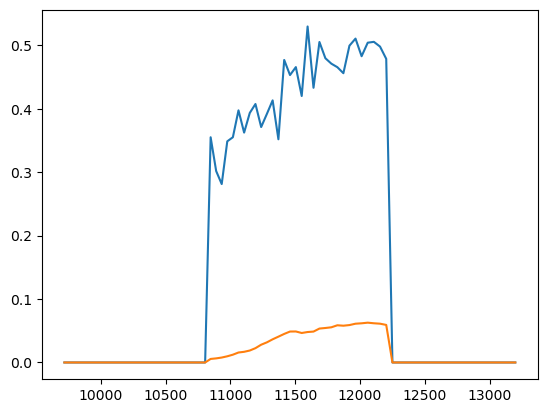

In [11]:
plt.plot(mb_R.oned_spectrum()['F115W']['wave'], mb_R.oned_spectrum()['F115W']['flux'])
plt.plot(mb_R.oned_spectrum()['F115W']['wave'], mb_R.oned_spectrum()['F115W']['contam'])

In [10]:
import matplotlib.pylab as plt

In [25]:
from astropy.io import ascii as asc

In [75]:

base_path = "/Users/knedkova/Work/2024PASSAGE/data/"+ "Par"+ str(28)+ "/Spectra/Par"+ str(28)+ "_" + str(6).zfill(5)

specnameg1_R = (base_path + ".F115W_1D_R.dat")
specnameg2_R = (base_path + ".F150W_1D_R.dat")
specnameg3_R = (base_path + ".F200W_1D_R.dat")


In [78]:
tab_blue_R = asc.read(specnameg2_R, names=["lambda","flux","ferror","contam","zero"])
tab_blue_R_contam = np.copy(tab_blue_R)
tab_blue_R_contam["flux"] = tab_blue_R["flux"] + tab_blue_R["contam"]  

In [79]:
tab_blue_R

lambda,flux,ferror,contam,zero
float64,float64,float64,float64,int64
12819.201485620451,1.232067831315147e-21,5.016545169530969e-21,0.0,0
12857.662061275081,1.232067831315147e-21,5.016545169530969e-21,0.0,0
12896.238018570266,1.232067831315147e-21,5.016545169530969e-21,0.0,0
12934.929703650672,1.232067831315147e-21,5.016545169530969e-21,0.0,0
12973.737463699392,1.232067831315147e-21,5.016545169530969e-21,0.0,0
13012.661646941073,1.232067831315147e-21,5.016545169530969e-21,0.0,0
13051.70260264503,1.232067831315147e-21,5.016545169530969e-21,0.0,0
13090.860681128388,1.232067831315147e-21,5.016545169530969e-21,0.0,0
13130.136233759222,1.232067831315147e-21,5.016545169530969e-21,0.0,0


In [61]:
tab_blue_R_contam["flux"] = tab_blue_R["flux"] + tab_blue_R["contam"]  

In [62]:
tab_blue_R_contam

lambda,flux,ferror,contam,zero
float64,float64,float64,float64,int64
16818.99609744206,0.0,5.2211980925903045e-21,0.0,0
16857.031248307125,0.0,5.2211980925903045e-21,0.0,0
16895.152408270704,0.0,5.2211980925903045e-21,0.0,0
16933.35977182565,0.0,5.2211980925903045e-21,0.0,0
16971.653533904624,0.0,5.2211980925903045e-21,0.0,0
17010.033889881088,0.0,5.2211980925903045e-21,0.0,0
17048.501035570305,0.0,5.2211980925903045e-21,0.0,0
17087.05516723034,0.0,5.2211980925903045e-21,0.0,0
17125.69648156305,0.0,5.2211980925903045e-21,0.0,0


In [63]:
tab_blue_R

lambda,flux,ferror,contam,zero
float64,float64,float64,float64,int64
16818.99609744206,0.0,5.2211980925903045e-21,0.0,0
16857.031248307125,0.0,5.2211980925903045e-21,0.0,0
16895.152408270704,0.0,5.2211980925903045e-21,0.0,0
16933.35977182565,0.0,5.2211980925903045e-21,0.0,0
16971.653533904624,0.0,5.2211980925903045e-21,0.0,0
17010.033889881088,0.0,5.2211980925903045e-21,0.0,0
17048.501035570305,0.0,5.2211980925903045e-21,0.0,0
17087.05516723034,0.0,5.2211980925903045e-21,0.0,0
17125.69648156305,0.0,5.2211980925903045e-21,0.0,0


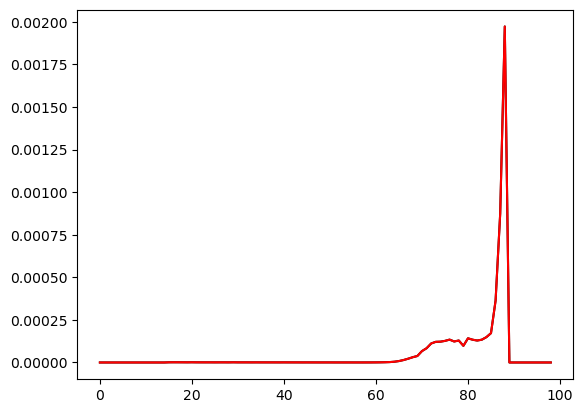

In [84]:
plt.plot( tab_blue_R_contam['flux'] - tab_blue_R['flux'], 'k-')
plt.plot( tab_blue_R_contam['contam'], 'r-')
plt.show()

In [85]:
contam

NameError: name 'contam' is not defined